# Comparación de resultados

Se comparan los resultados obtenidos con los distintos métodos de clustering. Tanto los calculados con python como los que son generados por R o Geoda. 

In [38]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sklearn as sk
import sys
import pickle
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from elegir_modelo import *
import procesos
import lq

In [40]:
# Ejecutar primero el archivo de lectura_datos.py en caso de que no exista covid_periodos.shp
dir_principal = os.getcwd()
dir_datos = dir_principal+'\\datos'

covid = gpd.read_file(dir_datos+'/covid_periodos.shp', index = True)
covid = covid.set_index(['link','mes']).sort_index(level = 0)
covid = covid.loc[pd.IndexSlice[:,'2020-03':],:]
covid = covid.to_crs('POSGAR94')

# Separamos los campos geometricos del dataframe
geo = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry']
geo = geo.reset_index(level = 'mes', drop = True)
centroides = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry'].to_crs('POSGAR94').centroid
centroides = centroides.reset_index(level = 'mes', drop = True)
print("las cordenadas CRS son: "+str(geo.crs))
codiprov = covid.loc[pd.IndexSlice[:,'2021-01'],['codpcia','departamen','provincia']]


columnas = ['clasificac', 'fallecido']

# Variables acumuladas a partir del mes que todas tienen al menos 1 

covid_acum = covid[columnas].groupby(covid.index.get_level_values(0)).cumsum()
# buscamos el mes en que todos los dptos tienen al menos 1 contagio
mes = 0
valor = True
while valor == True:
    Mes = covid.index.get_level_values(1).unique()[mes]
    valor = np.any(covid_acum.loc[pd.IndexSlice[:,Mes],'clasificac'] == 0)
    mes +=1
print("El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: "+str(Mes))
covid_acum['personas'] = covid.personas

covid2 = covid_acum.loc[pd.IndexSlice[:,Mes:],:]

las cordenadas CRS son: POSGAR94
El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: 2021-01


C:\Users\Pablo\anaconda3\envs\covid\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  del sys.path[0]


In [41]:
from lq import *
from sklearn.metrics import silhouette_score,  calinski_harabasz_score

lqcovid = lq_peri(covid_acum[['fallecido','personas']])
lqcovid1 = lq_peri(covid_acum[['clasificac','personas']])
lqcovid3 = lq_peri(covid2[['fallecido','clasificac']])

def df_datos(df):
    mes = ['2020-03']
    df = df.copy().set_index('link')
    col = list(df.columns)
    ind = col.index('personas')
    return df[col[:ind]].copy()

def siluetas(X, model):
    X_ = df_datos(X)
    return silhouette_score(X_, X[model])
def calinski(X, model):
    X_ = df_datos(X)
    return sk.metrics.calinski_harabasz_score(X_, X[model])
def inv_davies_bouldin(X,model):
    X_ = df_datos(X)
    return (sk.metrics.davies_bouldin_score(X_,X[model]))**-1
def indice_lq(X, model):
    X_ = df_datos(X)
    grupos = X[model].values
    ind = lqcovid1.calcular_indice_debil(grupos)
    ind2 = lqcovid2.calcular_indice_debil(grupos)
    return 1-((ind+ind2)/2)

In [42]:
archivo = 'Resultados/R_resultados/fallec.shp'
covid_rdos =gpd.read_file('Resultados/R_resultados/fallec.shp')
#df = df.set_index(df.link.astype(int))
#df = df.drop('link', axis = 1)
[[siluetas(covid_rdos,'sk'),siluetas(covid_rdos,'redcap'),siluetas(covid_rdos,'schc')],
[indice_lq(covid_rdos,'sk'),indice_lq(covid_rdos,'redcap'),indice_lq(covid_rdos,'schc')]]

[[-0.2950564275368649, -0.26612271212099103, -0.6124843471834203],
 [0.4516636957813428, 0.48704693998811655, 0.333184789067142]]

In [43]:
archivos = ['fallec', 'fallec_pca', 'positiv', 'positiv_pca','fall_pos','fall_pos_pca']
result = {}
for a in archivos:
    arch = 'df_R/'+a+'.shp'
    df = gpd.read_file(arch)
    r = [[siluetas(df,'sk'),siluetas(df,'redcap'),siluetas(df,'schc')],
    [calinski(df,'sk'),calinski(df,'redcap'),calinski(df,'schc')],
    [inv_davies_bouldin(df,'sk'),inv_davies_bouldin(df,'redcap'),inv_davies_bouldin(df,'schc')], 
    [indice_lq(df,'sk'),indice_lq(df,'redcap'),indice_lq(df,'schc')]]
    r = pd.DataFrame(r, columns = ('sk','redcap','schc'), index = ['sil','cal','dav','lqg'])
    result[a] = r
    

In [44]:
for k in result.keys():
    print(k),
    print(result[k])

fallec
            sk     redcap      schc
sil  -0.295056  -0.266123 -0.612484
cal  16.187580  15.676727  1.319989
dav   0.367650   0.345572  0.872176
lqg   0.451664   0.487047  0.333185
fallec_pca
            sk     redcap      schc
sil  -0.318379  -0.357582 -0.520127
cal  76.097682  68.223360  1.133577
dav   0.160671   0.087132  0.459595
lqg   0.506269   0.513666  0.300624
positiv
             sk      redcap      schc
sil    0.248795    0.281476 -0.144715
cal  108.527928  123.649623  1.545357
dav    0.725367    0.759896  0.851602
lqg    0.591176    0.585294  0.097059
positiv_pca
             sk      redcap      schc
sil    0.204395    0.177647 -0.212282
cal  107.584460  106.590642  0.708889
dav    0.600864    0.533063  0.732134
lqg    0.602941    0.673529  0.050000
fall_pos
            sk      redcap      schc
sil   0.187754    0.191917 -0.005955
cal  88.304911  117.160714  1.558539
dav   0.123380    0.259079  1.236087
lqg   0.532353    0.655882  0.258824
fall_pos_pca
            sk 

In [45]:
cont = os.listdir('Resultados')
objetos = {}
for fichero in cont:
    if fichero.endswith('.pickle'):
        with open('Resultados/'+fichero, 'rb') as f:
            met = pickle.load(f)
        nomb = fichero[:fichero.find('.')]
        objetos[nomb] = met

In [46]:
l = []
for i in objetos.keys():
    df = objetos[i].best_metrics_.copy()
    model = objetos[i].best_model_
    df['grupos'] = model['modelo'].iloc[0].n_clusters
    df['modelo'] = model['modelo'].iloc[0]
    df['bd'] = i
    l.append(df)    

res = pd.concat(l)

In [47]:
res.sort_values('lqg') 

,sil,cal,dav,lqg,grupos,modelo,bd
3,-0.172475,30.354043,0.394704,0.565775,12,"KShape(n_clusters=12, tol=0.0001)",kshapefallypos
60,0.719963,81.207316,8.626661,0.598739,8,"AgglomerativeClustering(affinity='l2',\n ...",aglo_geofallypos
37,0.477475,125.544090,0.441916,0.617647,9,"AgglomerativeClustering(affinity='l2',\n ...",aglo_geo2fallypos
31,0.771511,95.707823,10.014740,0.621569,6,"AgglomerativeClustering(affinity='l1', linkage...",aglofallypos
121,0.771511,95.707823,10.014740,0.621569,6,"AgglomerativeClustering(affinity='l1', linkage...",aglofallypos
0,0.546328,579.465696,1.571337,0.644118,5,KMeans(n_clusters=5),kmeansfallypos
1,0.698434,764.912772,1.372969,0.654412,8,"TimeSeriesKMeans(metric='dtw', n_clusters=8, t...",tskmfallypos
14,0.396219,514.924140,1.326351,0.668903,19,KMeans(n_clusters=19),ae_kmfallypos
151,0.386088,404.473066,1.260662,0.678431,6,"AgglomerativeClustering(affinity='cosine', lin...",ae_aglofallypos
6,0.395798,471.725021,1.324383,0.689840,11,KMeans(n_clusters=11),ae_tskmfallypos


In [49]:
result['fallec'].T.to_excel('Resultados/indices.xlsx', sheet_name = 'espacial')
res.to_excel('Resultados/indices2.xlsx', sheet_name = 'otros algorit')

<AxesSubplot:>

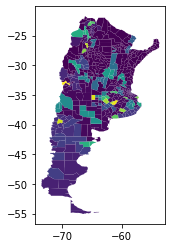

In [15]:
fig, ax = plt.subplots()
covid_rdos.plot('sk', figsize = (10,8), ax = ax)
#fig.savefig('Resultados/Imagenes/skatter.png')

In [50]:
covid_pcia = covid_acum.groupby([covid.codpcia, covid_acum.index.get_level_values(1)]).sum()

In [52]:
best_model = objetos['ae_tskmfallypos'].best_model_['modelo'].iloc[0]
eva = evaluaciones_lq(best_model.labels_, ['fallecido','clasificac'], 'personas')
eva.calcular_indices(covid_acum)

{'fallecido': (0.41711229946524053, 50.69979064343607),
 'clasificac': (0.20320855614973266, 1284.7878175994706)}

In [126]:
# determinamos que grupo es el que menos intersecciones tiene
heterog = eva.rdos_glob['fallecido']['lqperi'].matriz_intersec_deb.mean(axis = 1)

# calculamos la homogeneidad del grupo mas separado de todos
indices = []
for i in range(11):
    indices.append(np.sqrt(eva.rdos_loc['fallecido']['regiones'][i]['indices']))
indices = np.array(indices)
indices
totales = pd.DataFrame(eva.peri_col.fit_transform(covid_acum['fallecido'])).groupby(best_model.labels_).sum().mean(axis = 1)

fall = pd.DataFrame(np.c_[heterog.reshape(-1,1), indices[:,0], totales.values.reshape(-1,1)],index = range(1,12), columns = ('ind LQ', 'homog','total'))
fall.to_excel('Resultados/fallhomog.xlsx')

In [127]:
# determinamos que grupo es el que menos intersecciones tiene
heterog = eva.rdos_glob['clasificac']['lqperi'].matriz_intersec_deb.mean(axis = 1)

# calculamos la homogeneidad del grupo mas separado de todos
indices = []
for i in range(11):
    indices.append(np.sqrt(eva.rdos_loc['clasificac']['regiones'][i]['indices']))
indices = np.array(indices)
indices
totales = pd.DataFrame(eva.peri_col.fit_transform(covid_acum['clasificac'])).groupby(best_model.labels_).sum().mean(axis = 1)

fall = pd.DataFrame(np.c_[heterog.reshape(-1,1), indices[:,0], totales.values.reshape(-1,1)],index = range(1,12), columns = ('ind LQ', 'homog','total'))
fall.to_excel('Resultados/poshomog.xlsx')

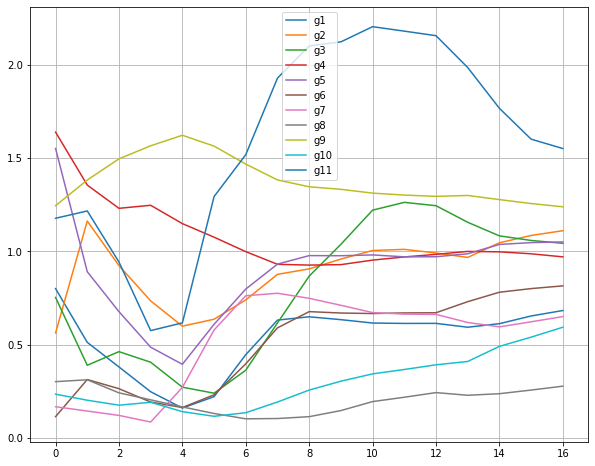

In [85]:
plt.rcParams["figure.figsize"] = (10,8)
for i in range(11):
    plt.plot(np.array(eva.rdos_glob['fallecido']['lqperi'].lqs_).reshape(17,11)[:,i], label = 'g'+str(i+1))
plt.legend()
plt.grid()
plt.savefig('Resultados/evol_fall.jpg')

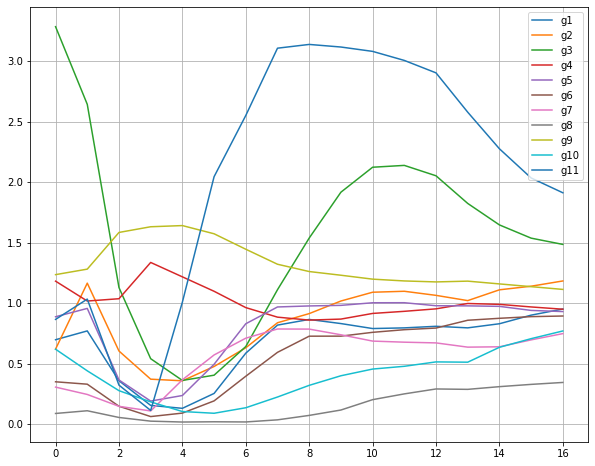

In [86]:
plt.rcParams["figure.figsize"] = (10,8)
for i in range(11):
    plt.plot(np.array(eva.rdos_glob['clasificac']['lqperi'].lqs_).reshape(17,11)[:,i], label = 'g'+str(i+1))
plt.legend()
plt.grid()
plt.savefig('Resultados/evol_pos.jpg')

<AxesSubplot:>

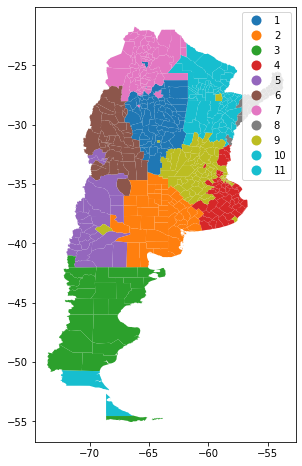

In [96]:
covid_rdos.plot(best_model.labels_+1, legend = True, categorical = True)

## Gráfico de evolución del covid por mes

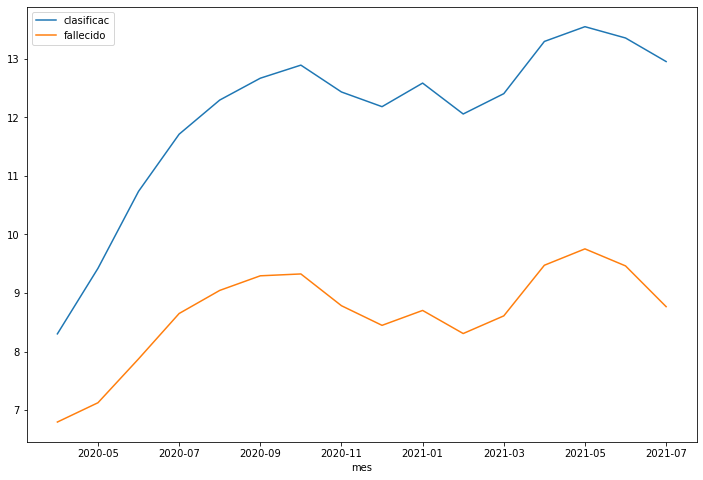

In [14]:
fig, ax = plt.subplots()
np.log(covid_pcia.groupby(level=1).sum()[['clasificac','fallecido']].diff(1)).plot(figsize = (12,8), ax = ax)
fig.savefig('Resultados/Imagenes/covid_total.png')


## Mapas de coropletes meses de picos

In [15]:
covid_acum_geo = covid_acum.copy()
covid_acum_geo['geometry'] = covid['geometry'] 
covid_acum_geo = gpd.GeoDataFrame(covid_acum_geo, crs = 'POSGAR94')

In [16]:
covid_acum_geo['lq'] = lq(covid_acum_geo, 'fallecido','personas')[2]

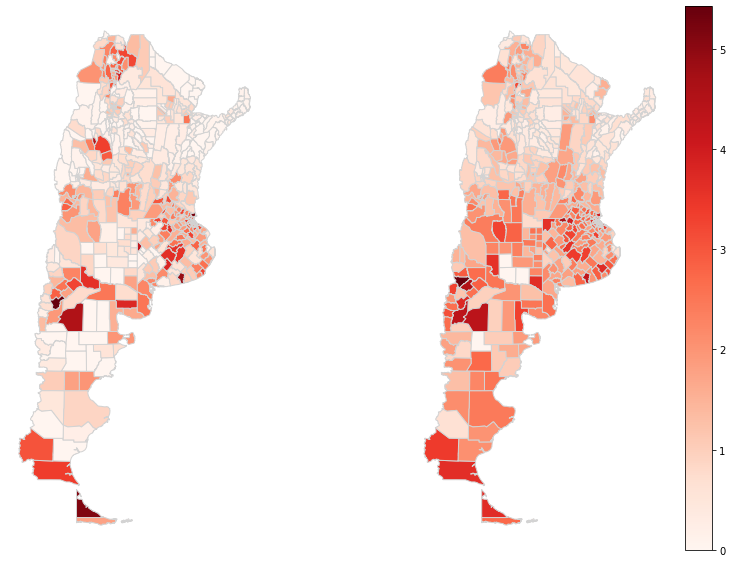

In [17]:
plt.rcParams["figure.figsize"] = (14,10)
fig, ax = plt.subplots(1,2)
covid_acum_geo.loc[pd.IndexSlice[:,'2020-10'],:].plot('lq', ax = ax[0], cmap = 'Reds', edgecolor = 'lightgray')
covid_acum_geo.loc[pd.IndexSlice[:,'2021-05'],:].plot('lq', ax = ax[1], legend = True, cmap = 'Reds', edgecolor = 'lightgray')
ax[0].set_axis_off()
ax[1].set_axis_off()
fig.savefig('Resultados/Imagenes/lq_meses_pico.png')

In [18]:
archivo = 'df_R/guerry.shp'
df =gpd.read_file(archivo)
columns = ['Crm_prs','Crm_prp','Litercy','Donatns','Infants','Suicids']

In [19]:
[silhouette_score(df[columns], df['maxp']),
sk.metrics.calinski_harabasz_score(df[columns], df['maxp']),
sk.metrics.davies_bouldin_score(df[columns],df['maxp'])]

[-0.021633184153324398, 22.417855290266427, 2.2417857949924525]

In [128]:
covid_acum

clasificac  fallecido  personas
link  mes                                     
2001  2020-03        14.0        2.0    205886
      2020-04        91.0       12.0    205886
      2020-05      1874.0       43.0    205886
      2020-06      2602.0       66.0    205886
      2020-07      3816.0      109.0    205886
...                   ...        ...       ...
94014 2021-03     10143.0      164.0     56956
      2021-04     11407.0      173.0     56956
      2021-05     12519.0      183.0     56956
      2021-06     13101.0      189.0     56956
      2021-07     13661.0      193.0     56956

[8925 rows x 3 columns]